<a href="https://colab.research.google.com/github/restful3/ds4th_study/blob/main/source/%ED%8A%B8%EB%9E%9C%EC%8A%A4%ED%8F%AC%EB%A8%B8%EB%A5%BC_%ED%99%9C%EC%9A%A9%ED%95%9C_%EC%9E%90%EC%97%B0%EC%96%B4_%EC%B2%98%EB%A6%AC/02_classification_PJH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 코랩을 사용하지 않으면 이 셀의 코드를 주석 처리하세요.
!git clone https://github.com/rickiepark/nlp-with-transformers.git
%cd nlp-with-transformers
from install import *
install_requirements(chapter=2)

Cloning into 'nlp-with-transformers'...
remote: Enumerating objects: 653, done.
remote: Counting objects: 100% (84/84), done.
remote: Compressing objects: 100% (75/75), done.
remote: Total 653 (delta 47), reused 15 (delta 8), pack-reused 569
Receiving objects: 100% (653/653), 62.41 MiB | 24.02 MiB/s, done.
Resolving deltas: 100% (335/335), done.
/content/nlp-with-transformers
⏳ Installing base requirements ...
✅ Base requirements installed!
Using transformers v4.35.2
Using datasets v2.16.1
Using accelerate v0.26.1
Using sentencepiece v0.1.99
Using umap v0.5.5


# 텍스트 분류

# 본 실습의 최종 목적
- 입력받은 텍스트의 감정 상태를 분류해서 맞추는 모델
   ("I saw a movie today and it was really good.")
- huggingface_hub 데이터셋 활용 (emotion)

<img alt="Hugging Face Pipeline" caption="A typical pipeline for training transformer models with the image:images/logo.png[hf,13,13] Datasets, image:images/logo.png[hf,13,13] Tokenizers, and image:images/logo.png[hf,13,13] Transformers libraries" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter02_hf-libraries.png?raw=1" id="hf-libraries"/>

## 데이터셋

### 허깅 페이스 데이터셋
Hugging Face Hub는 머신러닝 모델, 데모, 데이터 세트 및 메트릭을 공유할 수 있는 곳

In [2]:
from huggingface_hub import list_datasets
all_datasets = [ds.id for ds in list_datasets()] # Hugging Face Hub에서 제공하는 모든 데이터셋의 이름을 리스트 형태로 반환

print(f"현재 허브에는 {len(all_datasets)}개의 데이터셋이 있습니다.")
print(f"처음 10개 데이터셋: {all_datasets[:10]}")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


현재 허브에는 103492개의 데이터셋이 있습니다.
처음 10개 데이터셋: ['acronym_identification', 'ade_corpus_v2',
'UCLNLP/adversarial_qa', 'aeslc', 'afrikaans_ner_corpus', 'ag_news',
'allenai/ai2_arc', 'air_dialogue', 'ajgt_twitter_ar', 'allegro_reviews']




### load_dataset() 함수로 emotion 데이터셋 불러오기

- (emotion 데이터셋) 감정 분류를 위한 데이터셋으로, 7가지 감정(분노, 혐오, 두려움, 기쁨, 슬픔, 놀람, 중립)에 대한 텍스트 데이터가 포함

In [3]:
from datasets import load_dataset
emotions = load_dataset("emotion")

/usr/local/lib/python3.10/dist-packages/datasets/load.py:1429: FutureWarning: The repository for emotion contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/emotion
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

### 미리 정의된 클래스 집합을 가지는 필드를 지정할 때 사용

In [4]:
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [5]:
from datasets import ClassLabel

emotions['train'].features['label'] = ClassLabel(
    num_classes=6, # num_classes=6: 여섯 개의 클래스가 있다고 지정
    names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']) # 숫자 레이블에 해당하는 클래스의 이름을 지정

In [6]:
train_ds = emotions["train"]
train_ds

# print(train_ds.column_names)
# print(train_ds.features)

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [7]:
train_ds[0]

{'text': 'i didnt feel humiliated', 'label': 0}

In [8]:
print(train_ds[:5])

{'text': ['i didnt feel humiliated', 'i can go from feeling so hopeless to so
damned hopeful just from being around someone who cares and is awake', 'im
grabbing a minute to post i feel greedy wrong', 'i am ever feeling nostalgic
about the fireplace i will know that it is still on the property', 'i am feeling
grouchy'], 'label': [0, 0, 3, 2, 3]}


### 허브에 필요한 데이터셋이 없는 경우

In [9]:
# dataset_url = "https://huggingface.co/datasets/transformersbook/emotion-train-split/raw/main/train.txt"
# !wget {dataset_url}

In [10]:
# !head -n 1 train.txt

In [11]:
# emotions_local = load_dataset("csv", data_files="train.txt", sep=";",
#                               names=["text", "label"])

In [12]:
# dataset_url = "https://huggingface.co/datasets/transformersbook/emotion-train-split/raw/main/train.txt"
# emotions_remote = load_dataset("csv", data_files=dataset_url, sep=";",
#                                names=["text", "label"])

### 데이터셋에서 데이터프레임으로

In [13]:
import pandas as pd

emotions.set_format(type="pandas") # set_format 메서드를 사용하여 데이터셋의 표현 방식을 설정
df = emotions["train"][:]
df.head()

# emotions["train"].features['label'].__class__ #'emotions' 데이터셋의 훈련 세트에서 'label' 특성의 클래스를 확인
# datasets.features.features.ClassLabel

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [14]:
def label_int2str(row): # 레이블을 해당하는 문자열로 변환
    return emotions["train"].features["label"].int2str(row)

df["label_name"] = df["label"].apply(label_int2str)
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


### 클래스 분포 살펴 보기

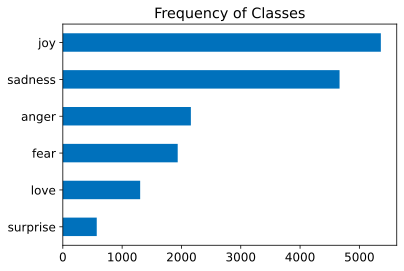

In [15]:
import matplotlib.pyplot as plt

df["label_name"].value_counts(ascending=True).plot.barh() # "label_name" 열의 각 고유 값의 빈도를 계산해서 그 빈도를 수평 막대 그래프(bar chart)로 시각화
plt.title("Frequency of Classes")
plt.show()

### 트윗 길이 확인

In [81]:
df["Words Per Tweet"] = df["text"].str.split().apply(len)
df.boxplot("Words Per Tweet", by="label_name", grid=False, showfliers=True,
           color="black")
plt.suptitle("")
plt.xlabel("")
plt.show()

KeyError: 'text'

In [17]:
emotions.reset_format() # 데이터셋의 표현 방식을 기본 형식(default format)으로 재설정

In [18]:
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

## 텍스트에서 토큰으로

### 문자 토큰

In [19]:
text = "Tokenizing text is a core task of NLP."
tokenized_text = list(text)
print(tokenized_text)

['T', 'o', 'k', 'e', 'n', 'i', 'z', 'i', 'n', 'g', ' ', 't', 'e', 'x', 't', ' ',
'i', 's', ' ', 'a', ' ', 'c', 'o', 'r', 'e', ' ', 't', 'a', 's', 'k', ' ', 'o',
'f', ' ', 'N', 'L', 'P', '.']


In [20]:
token2idx = {ch: idx for idx, ch in enumerate(sorted(set(tokenized_text)))} #딕셔너리 컴프리헨션을 사용하여 token2idx 딕셔너리를 생성
print(token2idx)

# set(tokenized_text) : 중복제거
# sorted(set(tokenized_text)) : 고유한 문자들을 알파벳 순으로 정렬
# enumerate(sorted(set(tokenized_text))): 정렬된 집합의 각 문자에 대한 인덱스와 문자의 쌍을 생성
# {ch: idx for idx, ch in enumerate(sorted(set(tokenized_text)))} : 각 문자가 정렬된 문자 집합에서의 해당 인덱스에 매핑된 딕셔너리를 생성

{' ': 0, '.': 1, 'L': 2, 'N': 3, 'P': 4, 'T': 5, 'a': 6, 'c': 7, 'e': 8, 'f': 9,
'g': 10, 'i': 11, 'k': 12, 'n': 13, 'o': 14, 'r': 15, 's': 16, 't': 17, 'x': 18,
'z': 19}


In [21]:
input_ids = [token2idx[token] for token in tokenized_text]
print(input_ids)

[5, 14, 12, 8, 13, 11, 19, 11, 13, 10, 0, 17, 8, 18, 17, 0, 11, 16, 0, 6, 0, 7,
14, 15, 8, 0, 17, 6, 16, 12, 0, 14, 9, 0, 3, 2, 4, 1]


In [22]:
''' 원핫 인코딩 연습 '''
categorical_df = pd.DataFrame(
    {"Name": ["Bumblebee", "Optimus Prime", "Megatron"], "Label ID": [0,1,2]})
categorical_df

,Name,Label ID
0,Bumblebee,0
1,Optimus Prime,1
2,Megatron,2


In [23]:
pd.get_dummies(categorical_df["Name"])

,Bumblebee,Megatron,Optimus Prime
0,1,0,0
1,0,0,1
2,0,1,0


In [24]:
import torch
import torch.nn.functional as F


input_ids = torch.tensor(input_ids)
one_hot_encodings = F.one_hot(input_ids, num_classes=len(token2idx))
one_hot_encodings.shape

torch.Size([38, 20])

In [25]:
print(input_ids)
print(input_ids.shape)
one_hot_encodings

tensor([ 5, 14, 12,  8, 13, 11, 19, 11, 13, 10,  0, 17,  8, 18, 17,  0, 11, 16,
         0,  6,  0,  7, 14, 15,  8,  0, 17,  6, 16, 12,  0, 14,  9,  0,  3,  2,
         4,  1])
torch.Size([38])


tensor([[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0,

In [26]:
print(f"토큰: {tokenized_text[0]}")
print(f"텐서 인덱스: {input_ids[0]}")
print(f"원-핫 인코딩: {one_hot_encodings[0]}")

토큰: T
텐서 인덱스: 5
원-핫 인코딩: tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


In [27]:
''' one_hot 예시 '''
F.one_hot(torch.tensor([0,2]), num_classes=11).shape
# torch.tensor([0,2])는 [0, 2]를 포함하는 PyTorch 텐서를 생성
# F.one_hot() 함수를 사용하여 입력으로 주어진 텐서를 one-hot 형식으로 변환

torch.Size([2, 11])

In [28]:
F.one_hot(torch.tensor([0,2]), num_classes=11)

tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]])

In [29]:
import tensorflow as tf

tf.one_hot([0,1, 2], 1)

<tf.Tensor: shape=(3, 1), dtype=float32, numpy=
array([[1.],
       [0.],
       [0.]], dtype=float32)>

### 단어 토큰화

In [30]:
tokenized_text = text.split()
print(tokenized_text)

['Tokenizing', 'text', 'is', 'a', 'core', 'task', 'of', 'NLP.']


### 부분단어 토큰화

In [31]:
from transformers import AutoTokenizer # 주어진 사전 훈련 모델에 대한 적절한 토크나이저를 자동으로 로드

model_ckpt = "distilbert-base-uncased"
# 사전 훈련된 DistilBERT 모델의 식별자
# "uncased" 부분은 모델이 소문자 텍스트로 훈련되었음을 나타냄
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [32]:
print("원본 text")
print(text)
print("*"*50)
encoded_text = tokenizer(text)
print(encoded_text)
# attention_mask : 실제 텍스트 토큰에 대해 1을, 패딩 토큰에 대해 0을 가지는 이진 마스크로 구성
# [CLS] hello world [SEP] = [0, 1, 1, 0]

원본 text
Tokenizing text is a core task of NLP.
**************************************************
{'input_ids': [101, 19204, 6026, 3793, 2003, 1037, 4563, 4708, 1997, 17953,
2361, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [33]:
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)

print(tokens)
print(f'{len(tokens)}개')

['[CLS]', 'token', '##izing', 'text', 'is', 'a', 'core', 'task', 'of', 'nl',
'##p', '.', '[SEP]']
13개


In [34]:
print(tokenizer.convert_tokens_to_string(tokens))

[CLS] tokenizing text is a core task of nlp. [SEP]


In [35]:
print(tokenizer.vocab_size) # 현재 사용 중인 토크나이저의 어휘 크기 =  고유한 토큰의 수
print(tokenizer.model_max_length) # 모델에 입력되는 시퀀스의 최대 길이
print(tokenizer.model_input_names) # 모델의 입력으로 받을 값들의 key 값

30522
512
['input_ids', 'attention_mask']


In [36]:
tokenizer

DistilBertTokenizerFast(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

### 전체 데이터셋 토큰화하기

In [37]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True) # 해당 배치의 텍스트를 토큰화한 결과를 반환

In [38]:
print(f'첫번째 문장의 단어 수 : {len(tokenizer(emotions["train"][0]["text"])["input_ids"])}')
print(f'두번째 문장의 단어 수 : {len(tokenizer(emotions["train"][1]["text"])["input_ids"])}')

# print("첫번째 문장의 단어 수 :",len(tokenizer(emotions["train"][0]["text"])['input_ids']))
# print("두번째 문장의 단어 수 :", len(tokenizer(emotions["train"][1]["text"])['input_ids']))

print("*"*20)
print("\n")

print(tokenize(emotions["train"][:2]))

첫번째 문장의 단어 수 : 7
두번째 문장의 단어 수 : 23
********************


{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0,
0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000,
2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300,
102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
1, 1]]}


In [39]:
# 특수 토큰과 해당 토큰의 ID 추출하는 코드
tokens2ids = list(zip(tokenizer.all_special_tokens, tokenizer.all_special_ids))
data = sorted(tokens2ids, key=lambda x : x[-1])
df = pd.DataFrame(data, columns=["Special Token", "Special Token ID"])
df.T

# [PAD]: 0, Padding Token
# 시퀀스의 길이를 맞추기 위해 빈 시퀀스에 사용되는 토큰

# [UNK]: Unknown Token
# 어휘에 없는 단어

# [CLS]: 101, Classification Token
# 문장의 시작 부분에 추가되는 토큰

# [SEP]: 102, Separation Token
# 문장이나 시퀀스를 구분하는 역할을 하는 토큰, 주로 두 문장이나 두 시퀀스를 합칠 때 사용

# [MASK]: Mask Token
# 마스킹된 언어 모델 학습 등에서 사용되는 토큰, 임의의 단어나 토큰을 가리기 위해 사용

,0,1,2,3,4
Special Token,[PAD],[UNK],[CLS],[SEP],[MASK]
Special Token ID,0,100,101,102,103


<img alt="attention-mask" caption="For each batch, the input sequences are padded to the maximum sequence length in the batch; the attention mask is used in the model to ignore the padded areas of the input tensors" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter02_attention-mask.png?raw=1" id="attention-mask"/>

In [40]:
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)
print(emotions_encoded["train"].column_names)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

['text', 'label', 'input_ids', 'attention_mask']


In [41]:
emotions_encoded

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
})

## 텍스트 분류 모델 훈련하기

<img alt="encoder-classifier" caption="The architecture used for sequence classification with an encoder-based transformer; it consists of the model's pretrained body (blue) combined with a custom classification head (orange)" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter02_encoder-classifier.png?raw=1" id="encoder-classifier"/>

### 트랜스포머를 특성 추출기로 사용하기

<img alt="encoder-features" caption="In the feature-based approach, the DistilBERT model is frozen and just provides features for a classifier" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter02_encoder-feature-based.png?raw=1" id="encoder-features"/>

#### 사전 훈련된 모델 사용하기

In [42]:
# 객체와 Device 선언

from transformers import AutoModel

model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = AutoModel.from_pretrained(model_ckpt).to(device)

cuda


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

### 프레임워크 간의 상호 운영성

In [43]:
# from transformers import TFAutoModel

# tf_model = TFAutoModel.from_pretrained(model_ckpt)

In [44]:
# tf_xlmr = TFAutoModel.from_pretrained("xlm-roberta-base", from_pt=True)

#### 마지막 은닉 상태 추출하기

In [45]:
text = "this is a test"
inputs = tokenizer(text, return_tensors="pt")
# 토크나이저를 사용하여 입력 텍스트를 토큰화하고, 그 결과를 PyTorch 텐서로 반환
# return_tensors="pt" : 결과를 PyTorch 텐서로 반환하도록 지정한 부분
print(f"입력 텐서 크기: {inputs['input_ids'].size()}")
print(f'inputs 은 {inputs}')

입력 텐서 크기: torch.Size([1, 6])
inputs 은 {'input_ids': tensor([[ 101, 2023, 2003, 1037, 3231,  102]]),
'attention_mask': tensor([[1, 1, 1, 1, 1, 1]])}


In [46]:
print(inputs.items())
print(type(inputs))

dict_items([('input_ids', tensor([[ 101, 2023, 2003, 1037, 3231,  102]])),
('attention_mask', tensor([[1, 1, 1, 1, 1, 1]]))])
<class 'transformers.tokenization_utils_base.BatchEncoding'>


In [47]:
''' PyTorch를 사용하여 모델의 추론을 수행하는 코드 '''
# 딥 러닝 모델을 특정 디바이스에서 실행하고, 추론 결과를 얻기 위해 사용

# 1.데이터를 디바이스로 옮기기 위한 코드
inputs = {k:v.to(device) for k,v in inputs.items()}

# 2. 모델의 추론을 수행
with torch.no_grad(): # 모델이 가중치를 업데이트하지 않음, autograd 엔진을 꺼서 메모리를 절약하고 연산 속도를 높이기 위해 사용
    outputs = model(**inputs) # 모델에 입력을 전달하고, 모델이 출력하는 결과를 outputs 변수에 저장
                              # **inputs : 딕셔너리의 키와 값들을 키워드 인자로 변환하여 함수 또는 메서드에 전달하는 역할
print(outputs)

BaseModelOutput(last_hidden_state=tensor([[[-0.1565, -0.1862,  0.0528,  ...,
-0.1188,  0.0662,  0.5470],
         [-0.3575, -0.6484, -0.0618,  ..., -0.3040,  0.3508,  0.5221],
         [-0.2772, -0.4459,  0.1818,  ..., -0.0948, -0.0076,  0.9958],
         [-0.2841, -0.3917,  0.3753,  ..., -0.2151, -0.1173,  1.0526],
         [ 0.2661, -0.5094, -0.3180,  ..., -0.4203,  0.0144, -0.2149],
         [ 0.9441,  0.0112, -0.4714,  ...,  0.1439, -0.7288, -0.1619]]],
       device='cuda:0'), hidden_states=None, attentions=None)


In [48]:
print(outputs.last_hidden_state.size())

for key, value in outputs.items(): # outputs의 size 추출하기
    print(f"{key}의 shape: {value.shape}")

torch.Size([1, 6, 768])
last_hidden_state의 shape: torch.Size([1, 6, 768])


In [49]:
outputs.last_hidden_state[:,0].size()

torch.Size([1, 768])

In [50]:
''' 모델의 마지막 숨겨진(hidden) 상태를 추출하는 함수 '''
# 모델의 마지막 숨겨진 상태를 추출하고, 해당 상태를 딕셔너리 형태로 반환

def extract_hidden_states(batch):
    inputs = {k:v.to(device) for k,v in batch.items()
              if k in tokenizer.model_input_names} # 모델 입력을 변환하여 device로 이동 (리스트 → 딕셔너리)

    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state # 마지막 은닉 상태를 추출

    print("last_hidden_state")
    print(last_hidden_state)

    print("last_hidden_state[:,0]")
    print(last_hidden_state[:,0]) # 첫 번째 토큰에 해당하는 은닉 상태
    # 왜 첫 번째 토큰에 해당하는 은닉 상태가 의미가 있는 것인가?

    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()} # 추출된 마지막 은닉 상태를 딕셔너리 형태로 반환 후 넘파이로 변환

In [51]:
''' emotions_encoded 데이터셋은 선택된 열에 대해 PyTorch 텐서 형식으로 변환 '''
# set_format 메서드 : Hugging Face의 datasets 라이브러리에서 제공되는 메서드로 데이터셋의 표현 형식을 변경할 수 있음
# 특히, torch 포맷으로 변경하면 PyTorch의 DataLoader와 같은 PyTorch 기반의 기능을 사용할 수 있음
# PyTorch의 데이터로더를 사용하여 배치 단위로 데이터를 로드하고, 모델에 입력으로 전달하는 작업을 편리하게 수행할 수 있음

emotions_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])

In [52]:
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

last_hidden_state
tensor([[[-0.1168,  0.0986, -0.1296,  ...,  0.0587,  0.3543,  0.4042],
         [ 0.1325,  0.1516, -0.1169,  ..., -0.1119,  0.5562,  0.2908],
         [-0.1053,  0.2862,  0.1958,  ...,  0.0241,  0.0577, -0.3627],
         ...,
         [-0.1576,  0.0898, -0.0468,  ...,  0.0662, -0.0555, -0.3040],
         [-0.1641,  0.0944, -0.0331,  ...,  0.0501, -0.0445, -0.3198],
         [-0.2448,  0.1373,  0.3082,  ..., -0.0214,  0.1674, -0.1861]],

        [[-0.0324, -0.0323, -0.1957,  ..., -0.1747,  0.3546,  0.3028],
         [ 0.2920,  0.2514, -0.3510,  ..., -0.0705,  0.4476,  0.3433],
         [ 0.1124,  0.2768, -0.1371,  ..., -0.3548,  0.6641,  0.0977],
         ...,
         [-0.0134,  0.1927, -0.1303,  ..., -0.0439,  0.1111, -0.1301],
         [-0.0230,  0.1415, -0.1237,  ...,  0.0382,  0.0511, -0.1063],
         [-0.0700,  0.0209, -0.0227,  ...,  0.0192,  0.0657, -0.1047]],

        [[ 0.0397,  0.2022,  0.1423,  ..., -0.1141,  0.3394,  0.3958],
         [-0.1390,  0.4226,

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

last_hidden_state
tensor([[[-0.1344,  0.2183,  0.1235,  ..., -0.0053,  0.4089,  0.5558],
         [-0.3856,  0.5841,  0.8557,  ..., -0.1158,  0.3474,  0.8189],
         [-0.6706,  0.2642,  0.3804,  ...,  0.1742, -0.1075,  0.3054],
         ...,
         [-0.0192,  0.2574,  0.7946,  ..., -0.0606, -0.0300,  0.0772],
         [-0.3040,  0.3378,  0.4163,  ..., -0.0584, -0.0022, -0.1880],
         [-0.1114,  0.4629,  0.4237,  ..., -0.0445, -0.0657, -0.2780]],

        [[ 0.0801,  0.0826, -0.0419,  ...,  0.0544,  0.3219,  0.3625],
         [ 0.2591,  0.2980, -0.3295,  ...,  0.0975,  0.6726,  0.4906],
         [-0.3085,  0.4177,  0.3497,  ...,  0.0044,  0.1175,  0.6552],
         ...,
         [ 0.2877,  0.1912, -0.0093,  ..., -0.0049,  0.0910,  0.1408],
         [ 0.2511,  0.1843,  0.0122,  ...,  0.0458,  0.1013,  0.1536],
         [ 0.3906,  0.3358, -0.0083,  ...,  0.0643,  0.3086,  0.0023]],

        [[ 0.0147,  0.1749,  0.0430,  ...,  0.0880,  0.3221,  0.2580],
         [ 0.3866,  0.3713,

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

last_hidden_state
tensor([[[-0.0216,  0.1965,  0.0041,  ..., -0.0646,  0.4319,  0.5599],
         [-0.4236,  0.4446,  0.6385,  ..., -0.1813,  0.5174,  0.8447],
         [-0.3232, -0.1305,  0.0817,  ..., -0.1333, -0.0079,  0.1213],
         ...,
         [ 0.0801, -0.0661, -0.0128,  ..., -0.3176, -0.1904,  0.0036],
         [ 0.2277, -0.0867, -0.0559,  ..., -0.2281, -0.2148, -0.3028],
         [ 0.2139, -0.0760, -0.0265,  ..., -0.1154, -0.2775, -0.2979]],

        [[-0.0165,  0.3204, -0.0225,  ..., -0.1050,  0.4260,  0.4670],
         [-0.1441,  0.5567,  0.5354,  ...,  0.0413,  0.4918,  0.9446],
         [-0.1491,  0.0316,  0.2680,  ...,  0.1760,  0.3562, -0.1429],
         ...,
         [-0.0496,  0.1777,  0.3578,  ..., -0.1996,  0.0088,  0.1758],
         [ 0.1533,  0.1583,  0.1210,  ...,  0.1017,  0.0015, -0.2292],
         [ 0.1613,  0.1854,  0.1490,  ...,  0.1085,  0.0087, -0.2382]],

        [[-0.1114,  0.0211, -0.2773,  ..., -0.0317,  0.2478,  0.2088],
         [ 0.3072,  0.6437,

In [53]:
print(emotions_hidden["train"].column_names)
print(emotions_hidden["train"])

['text', 'label', 'input_ids', 'attention_mask', 'hidden_state']
Dataset({
    features: ['text', 'label', 'input_ids', 'attention_mask', 'hidden_state'],
    num_rows: 16000
})


#### 특성 행렬 만들기

In [54]:
import numpy as np

X_train = np.array(emotions_hidden["train"]["hidden_state"])
X_valid = np.array(emotions_hidden["validation"]["hidden_state"])
y_train = np.array(emotions_hidden["train"]["label"])
y_valid = np.array(emotions_hidden["validation"]["label"])
X_train.shape, X_valid.shape

((16000, 768), (2000, 768))

#### 훈련 세트 시각화하기

### UMAP(Uniform Manifold Approximation and Projection)
- 차원 축소 및 시각화를 위한 머신러닝 알고리즘
- t-SNE(t-Distributed Stochastic Neighbor Embedding)와 비슷한 목적
- 더 빠른 계산 속도와 더 좋은 보존력을 제공하며, 더 큰 데이터셋에 적용하기에도 효과적

In [55]:
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler

''' Label별 분포확인 '''
X_scaled = MinMaxScaler().fit_transform(X_train)

mapper = UMAP(n_components=2, metric="cosine").fit(X_scaled) # components가 2인 UMAP 객체를 생성/훈련
df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"]) # 2D 임베딩의 데이터프레임을 만듬

df_emb["label"] = y_train
df_emb.head()

,X,Y,label
0,3.982570,6.933514,0
1,-3.312345,6.017921,0
2,5.016802,3.383222,3
3,-2.683315,3.878954,2
4,-3.736542,4.213939,3


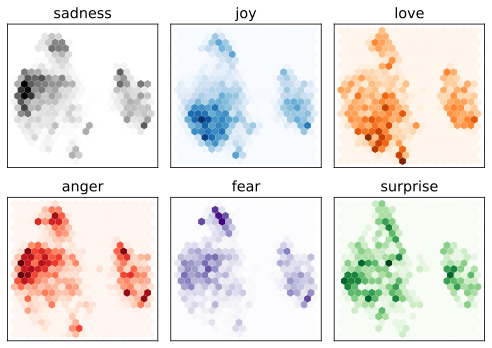

In [56]:
''' Label별 시각화 '''

fig, axes = plt.subplots(2, 3, figsize=(7,5))
axes = axes.flatten()
cmaps = ["Greys", "Blues", "Oranges", "Reds", "Purples", "Greens"]
labels = emotions["train"].features["label"].names

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_emb_sub = df_emb.query(f"label == {i}") # df_emb 데이터프레임에서 해당 레이블에 해당하는 행만 선택한 부분집합
    axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap,
                   gridsize=20, linewidths=(0,)) # hexbin 플롯
    axes[i].set_title(label)
    axes[i].set_xticks([]), axes[i].set_yticks([]) # x축과 y축의 눈금을 비활성화

plt.tight_layout()
plt.show()

#### 간단한 분류 모델 훈련하기

In [57]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)
lr_clf.score(X_valid, y_valid)

0.6335

In [58]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="most_frequent")
# strategy : stratified - 기본값, 훈련 데이터의 클래스 비율을 고려하여 예측
#            most_frequent - 가장 빈도가 높은 클래스로 예측
#            uniform - 균일한 확률로 예측
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_valid, y_valid)

0.352

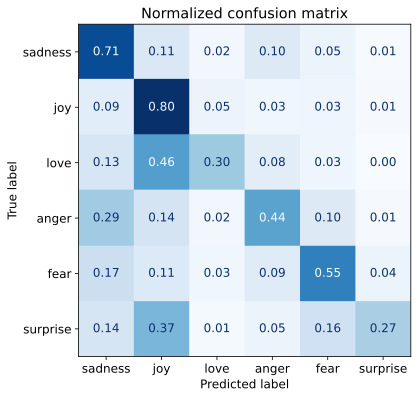

In [59]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

y_preds = lr_clf.predict(X_valid)
plot_confusion_matrix(y_preds, y_valid, labels)

### 트랜스포머 미세 튜닝하기

<img alt="encoder-tuning" caption="When using the fine-tuning approach the whole DistilBERT model is trained along with the classification head" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter02_encoder-fine-tuning.png?raw=1" id="encoder-tuning"/>

#### 사전 훈련된 모델 로드하기

In [60]:
''' Hugging Face의 transformers 라이브러리를 사용하여 시퀀스 분류를 위한 사전 훈련된 모델을 로드 '''

from transformers import AutoModelForSequenceClassification # 사전 훈련된 모델을 시퀀스 분류 작업에 맞게 조정하는 데 사용

num_labels = 6 # 분류하려는 레이블의 개수
model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt, num_labels=num_labels) # model_ckpt : 사전 훈련된 모델의 체크포인트 경로
         .to(device))

#### 성공 지표 정의하기

In [61]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids # pred 객체에서 실제 레이블을 가져와 labels 변수에 저장
    preds = pred.predictions.argmax(-1) # pred 객체에서 예측 결과를 가져와 가장 높은 확률을 가진 클래스의 인덱스를 선택하여 preds 변수에 저장
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

#### 모델 훈련하기

In [62]:
from huggingface_hub import notebook_login

notebook_login()

In [65]:
''' Hugging Face transformers 라이브러리를 사용하여 모델 훈련을 위한 Trainer와 TrainingArguments를 설정 '''
from transformers import Trainer, TrainingArguments

batch_size = 64 # 한 번에 처리되는 데이터 샘플의 개수
logging_steps = len(emotions_encoded["train"]) // batch_size #  훈련 데이터의 크기를 batch_size로 나눠서 실행할 스텝 수를 결정
model_name = f"{model_ckpt}-finetuned-emotion"

''' 훈련에 필요한 인자 설정 '''
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=2,                    # 훈련 에포크 수
                                  learning_rate=2e-5,                    # 학습률
                                  per_device_train_batch_size=batch_size,# 배치크기
                                  per_device_eval_batch_size=batch_size, # 배치크기
                                  weight_decay=0.01,                     # 가중치 감소
                                  evaluation_strategy="epoch",           # 평가 전략
                                  disable_tqdm=False,                    # tqdm 사용 여부
                                  logging_steps=logging_steps,           # 로깅 스텝
                                  push_to_hub=True,                      # Hub에 모델을 업로드할지 여부를 설정
                                  save_strategy="epoch",                 # 모델 저장 전략
                                  load_best_model_at_end=True,           # 최적의 모델 로드 여부
                                  log_level="error")                     # 로그 레벨

In [66]:
''' 모델 훈련을 관리 / 실행 '''

from transformers import Trainer

trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=emotions_encoded["train"],
                  eval_dataset=emotions_encoded["validation"],
                  tokenizer=tokenizer)
trainer.train();

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.830900,0.323778,0.902000,0.900985
2,0.252700,0.221858,0.923000,0.922915


In [67]:
preds_output = trainer.predict(emotions_encoded["validation"])
print(preds_output.metrics)

{'test_loss': 0.22185778617858887, 'test_accuracy': 0.923, 'test_f1':
0.9229154998434255, 'test_runtime': 3.8339, 'test_samples_per_second': 521.662,
'test_steps_per_second': 8.347}


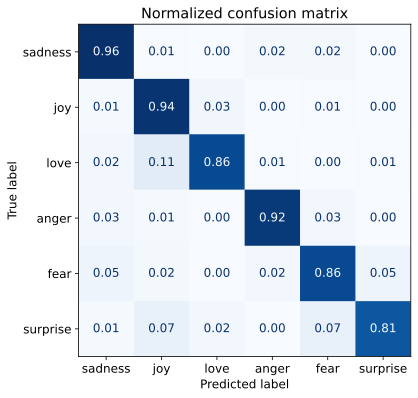

In [68]:
y_preds = np.argmax(preds_output.predictions, axis=1)
plot_confusion_matrix(y_preds, y_valid, labels)

### 사이드바: 케라스로 미세 튜닝하기

In [69]:
# from transformers import TFAutoModelForSequenceClassification

# tf_model = (TFAutoModelForSequenceClassification
#             .from_pretrained(model_ckpt, num_labels=num_labels))

In [70]:
# # 텐서플로 텐서로 변환할 열 이름
# tokenizer_columns = tokenizer.model_input_names

# tf_train_dataset = emotions_encoded["train"].to_tf_dataset(
#     columns=tokenizer_columns, label_cols="label", shuffle=True,
#     batch_size=batch_size)
# tf_eval_dataset = emotions_encoded["validation"].to_tf_dataset(
#     columns=tokenizer_columns, label_cols="label", shuffle=False,
#     batch_size=batch_size)

In [71]:
# import tensorflow as tf

# tf_model.compile(
#     optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
#     loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#     metrics=tf.metrics.SparseCategoricalAccuracy())

# tf_model.fit(tf_train_dataset, validation_data=tf_eval_dataset, epochs=2)

### 사이드바 끝

#### 오류 분석

In [72]:
''' 입력 배치를 받아 모델의 순전파를 수행하고, 예측된 레이블과 손실 값을 반환'''

# 1. 입력 텐서들을 모델과 같은 장치로 이동시킨 후
# 2. torch.no_grad() 블록 내에서 모델을 통해 순전파를 수행
# 3. torch.argmax() 함수를 사용하여 예측된 레이블을 구하고
# 4. cross_entropy() 함수를 사용하여 손실 값을 계산

from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
    # 모든 입력 텐서를 모델과 같은 장치로 이동
    inputs = {k:v.to(device) for k,v in batch.items()
              if k in tokenizer.model_input_names}

    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = cross_entropy(output.logits, batch["label"].to(device),
                             reduction="none")

    # 다른 데이터셋 열과 호환되도록 출력을 CPU로 옮깁니다.
    return {"loss": loss.cpu().numpy(),
            "predicted_label": pred_label.cpu().numpy()}

In [73]:
''' 데이터셋 구축 '''
# emotions_encoded 데이터셋의 형식을 파이토치 텐서로 변환
emotions_encoded.set_format("torch",
                            columns=["input_ids", "attention_mask", "label"])

# forward_pass_with_label함수로 손실 값을 계산
emotions_encoded["validation"] = emotions_encoded["validation"].map(
    forward_pass_with_label, batched=True, batch_size=16)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [74]:
# emotions_encoded 데이터셋의 형식을 다시 판다스 데이터프레임으로 변환
emotions_encoded.set_format("pandas")
cols = ["text", "label", "predicted_label", "loss"]
df_test = emotions_encoded["validation"][:][cols]
df_test["label"] = df_test["label"].apply(label_int2str) # "label" 열의 정수형 레이블을 문자열로 변환
df_test["predicted_label"] = (df_test["predicted_label"].apply(label_int2str)) # "predicted_label" 열의 정수형 예측된 레이블을 문자열로 변환

In [75]:
df_test.sort_values("loss", ascending=False).head(10)

,text,label,predicted_label,loss
1950,i as representative of everything thats wrong ...,surprise,sadness,6.026907
882,i feel badly about reneging on my commitment t...,love,sadness,5.635617
1963,i called myself pro life and voted for perry w...,joy,sadness,5.388359
1801,i feel that he was being overshadowed by the s...,love,sadness,5.342216
1509,i guess this is a memoir so it feels like that...,joy,fear,5.284535
1274,i am going to several holiday parties and i ca...,joy,sadness,5.183712
1500,i guess we would naturally feel a sense of lon...,anger,sadness,4.853401
1870,i guess i feel betrayed because i admired him ...,joy,sadness,4.829112
765,i feel super awkward and out of place right now,joy,sadness,4.775177
465,i would eventually go in to these stores but i...,joy,fear,4.742742


In [76]:
df_test.sort_values("loss", ascending=True).head(10)

,text,label,predicted_label,loss
1147,i type i feel bouncy and excited to get out my...,joy,joy,0.017119
578,i got to christmas feeling positive about the ...,joy,joy,0.017760
632,i feel he is an terrific really worth bet,joy,joy,0.017895
1873,i feel practically virtuous this month i have ...,joy,joy,0.018013
19,i had lunch with an old friend and it was nice...,joy,joy,0.018030
1780,ive explained that he is very creative and lov...,joy,joy,0.018143
604,i don t like to use the h word recklessly but ...,joy,joy,0.018182
1263,i feel this way about blake lively,joy,joy,0.018207
1421,i feel undeservingly lucky to be surrounded by...,joy,joy,0.018221
1861,im tired of feeling lethargic hating to work o...,sadness,sadness,0.018265


#### 모델 저장 및 공유

In [77]:
# trainer 객체의 push_to_hub() 메서드를 호출하여 모델을 Hugging Face Hub에 업로드
trainer.push_to_hub(commit_message="Training completed!") # commit_message : 업로드된 모델의 변경 사항을 설명하는 용도로 사용

CommitInfo(commit_url='https://huggingface.co/thebluedays/distilbert-base-uncased-finetuned-emotion/commit/c1b993fd326a97758dffda8601528af5387b6ab4', commit_message='Training completed!', commit_description='', oid='c1b993fd326a97758dffda8601528af5387b6ab4', pr_url=None, pr_revision=None, pr_num=None)

In [78]:
from transformers import pipeline

model_id = "haesun/distilbert-base-uncased-finetuned-emotion" # 사용할 모델의 식별자를 지정
classifier = pipeline("text-classification", model=model_id) #  pipeline 함수를 사용하여 텍스트 분류를 위한 파이프라인을 생성

config.json:   0%|          | 0.00/883 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/82.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [79]:
custom_tweet = "I saw a movie today and it was really good."
preds = classifier(custom_tweet, top_k=None) # top_k 매개변수를 None으로 설정하여 모든 감정 레이블에 대한 예측 결과를 반환

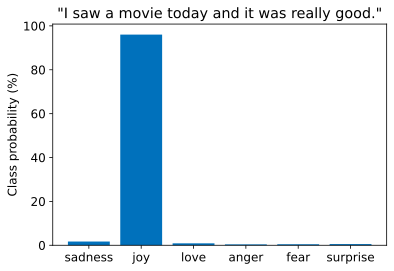

In [80]:
preds_sorted = sorted(preds, key=lambda d: d['label'])
preds_df = pd.DataFrame(preds_sorted)
plt.bar(labels, 100 * preds_df["score"], color='C0')
plt.title(f'"{custom_tweet}"')
plt.ylabel("Class probability (%)")
plt.show()